In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import yaml
import torch
from torch.utils.data import DataLoader
import timm
import pandas as pd
import matplotlib.pyplot as plt

# locally defined
import models
from dataset import EchoNetVideos, collate_video
import transforms as my_transforms
from utils import num_parameters, pad

In [3]:
artifact_dir = '/zfs/wficai/pda/model_run_artifacts/echonet_numheads_16/'

In [5]:
with open(artifact_dir + 'config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
    
# overrides
cfg['device'] = 'cpu'
cfg['dataloader_kwargs']['num_workers'] = 5
cfg['dataloader_kwargs']['batch_size'] = 80
cfg['dataloader_kwargs']['shuffle'] = True

In [6]:
cfg

{'artifact_folder': '/zfs/wficai/pda/model_run_artifacts/echonet_numheads_16/',
 'dataloader_kwargs': {'batch_size': 80,
  'num_workers': 5,
  'pin_memory': True,
  'shuffle': True},
 'device': 'cpu',
 'early_stopper_kwargs': {'patience': 10},
 'encoder_kwargs': {'checkpoint': None,
  'in_chans': 3,
  'model_name': 'resnet50d',
  'pretrained': True},
 'frame_csv': '/zfs/wficai/Data/echonet_data/frames.csv',
 'num_epochs': 100,
 'optim_kwargs': {'lr': 0.001, 'weight_decay': 0.001},
 'res': 112,
 'sched_kwargs': {'factor': 0.1, 'patience': 3, 'verbose': True},
 'time_downsample_kwargs': {'method': 'random', 'num_frames': 32},
 'video_csv': '/zfs/wficai/Data/echonet_data/train_val_test_1.0.csv',
 'vidnet_kwargs': {'drop_rate': 0.5,
  'num_heads': 16,
  'num_out': 2,
  'pooling_method': 'attn'}}

In [8]:
device = torch.device(cfg['device'])
    
# classifier network
print("Creating video classifier network.")
encoder = timm.create_model(**cfg['encoder_kwargs'], num_classes=0)
m = models.MedVidNet(encoder, **cfg['vidnet_kwargs']).to(device)
print(m.load_state_dict(torch.load(artifact_dir + 'model_checkpoint_video.ckpt')))
m.eval()

num_pars = num_parameters(m)
num_pars_encoder = num_parameters(encoder)
print(f"Number of trainable params: {num_pars} ({num_pars - num_pars_encoder} excluding encoder).")

# transforms
tfms = my_transforms.VideoTransforms(cfg['res'], time_downsample_kwargs = cfg['time_downsample_kwargs'])
tfms_test = tfms.get_transforms('test')
tfms_plot = tfms.get_transforms('plot')

# load data
print("Preparing datasets.")
df_videos = pd.read_csv(cfg['video_csv'])
df_frames = pd.read_csv(cfg['frame_csv'])

# create datasets
d_val = EchoNetVideos(df_videos, df_frames, transforms = tfms_test, split='VAL')
dl_val= DataLoader(d_val, collate_fn=collate_video, **cfg['dataloader_kwargs'])

print("Validation data size:", len(d_val))

Creating video classifier network.
<All keys matched successfully>
Number of trainable params: 23533410 (6146 excluding encoder).
Preparing datasets.
Validation data size: 1288


In [9]:
dl_iter = iter(dl_val)

In [10]:
batch = next(dl_iter)

In [11]:
with torch.no_grad():
    Y, attn = m(batch['video'].to(device), batch['num_frames'])

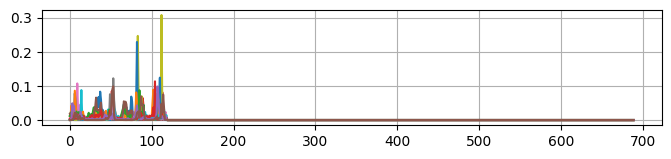

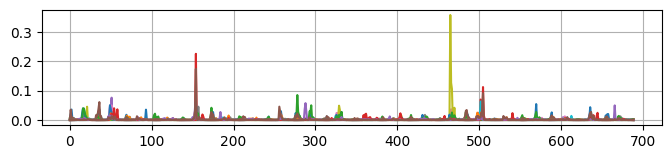

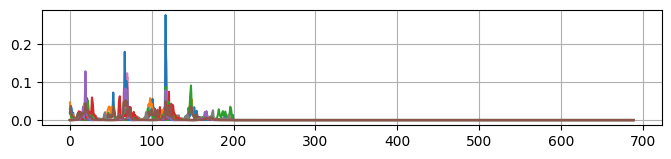

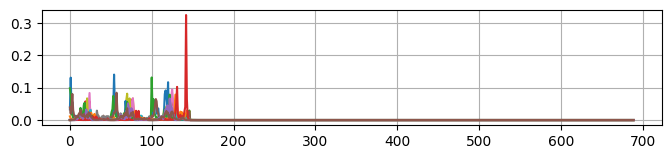

In [12]:
for ix in range(4):#range(cfg['dataloader_kwargs']['batch_size']):
    plt.gcf().set_size_inches(8, 1.5)
    at = attn[:,ix]
    
    for jx in range(cfg['vidnet_kwargs']['num_heads']):
        plt.plot(at[:,jx], label=jx)
        
    plt.grid()
    plt.show()

# Find the lowest entropy attention heads

In [13]:
#per video entropy for each head
entropy = torch.sum(-attn * attn.log(), axis=0)

# average entropy across videos
entropy = entropy.mean(axis=0)

entropy_sort_ix = entropy.argsort()

In [14]:
entropy[entropy_sort_ix]

tensor([2.7417, 2.7481, 3.3462, 3.3646, 3.3659, 3.4137, 3.6505, 3.6550, 3.7737,
        3.8066, 3.8760, 4.0400, 4.0642, 4.1368, 4.2157, 4.6252])

In [15]:
# use entropy to sort attention heads
attn = attn[...,entropy_sort_ix]

# Make the plot

In [16]:
k=10
# for each attention head, find the top from from each video
top_attn = attn.view(-1, cfg['vidnet_kwargs']['num_heads']).topk(k=k, dim=0).indices

In [17]:
top_attn.shape

torch.Size([10, 16])

In [18]:
vids = pad(batch['video'], batch['num_frames']).sigmoid()
vids = vids.view(-1, *vids.shape[-3:])
vids.shape

torch.Size([55200, 3, 112, 112])

In [19]:
top_frames = torch.concat([vids[top_attn[:,head_ix]][None] for head_ix in range(cfg['vidnet_kwargs']['num_heads'])], axis=0)
top_frames.shape

torch.Size([16, 10, 3, 112, 112])

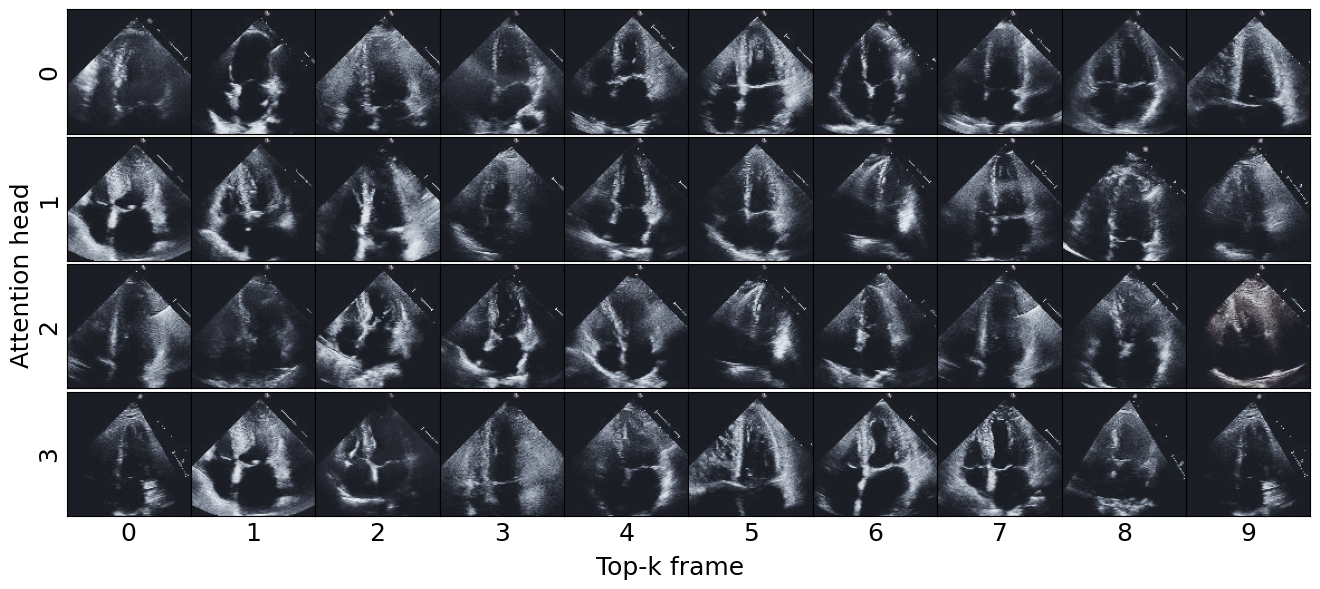

In [20]:
plt.rcParams['font.size']=18
heads_to_show = list(range(4))#list(range(cfg['vidnet_kwargs']['num_heads']))
nh = len(heads_to_show)
fig, ax = plt.subplots(nrows=nh, ncols=k, sharex=True, sharey=True)
scaling_factor = 1.5
fig.set_size_inches(scaling_factor * k/1.13, scaling_factor * nh)
for row_ix in range(nh):
    for col_ix in range(k):
        a = ax[row_ix][col_ix]
        a.imshow(top_frames[heads_to_show[row_ix], col_ix].permute(1,2,0).numpy())
        # a.axis('off')
        
        if col_ix==0:
            a.set_ylabel(f'{row_ix}')
        if row_ix==nh-1:
            a.set_xlabel(f'{col_ix}')
            
        a.tick_params(left = False, right = False , labelleft = False ,
                      labelbottom = False, bottom = False)
        

plt.tight_layout(h_pad = 0, w_pad = 0)
fig.text(0.5, 0.0, 'Top-k frame ', ha='center')
fig.text(0.0, 0.5, 'Attention head', va='center', rotation='vertical')
plt.savefig('../../paper/echonet_attention_head_examples.png', dpi=500, bbox_inches='tight')